In [3]:
# make dataframes from txt data
# each txt contains one tagesschau transcription
import os
import pandas as pd
import numpy as np
from wordcloud import WordCloud
from nltk.stem.snowball import SnowballStemmer
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation as LDA
import time
warnings.simplefilter("ignore", DeprecationWarning)
import spacy
import de_core_news_lg
nlp = de_core_news_lg.load(disable=['parser'])
#nlp.add_pipe(nlp.create_pipe('sentencizer'))
import datetime
from gensim import corpora,models
import pyLDAvis.gensim
from gensim.utils import simple_preprocess
from gensim.test.utils import common_corpus
from gensim.models import LdaSeqModel
from gensim.test.utils import datapath
from importlib import reload  # Not needed in Python 2
import logging
import re
logging.basicConfig(filename='gensim4.log',filemode='w',
                    #format="%(asctime)s:%(levelname)s:%(message)s",
                    level=logging.DEBUG)
reload(logging)
from gensim.models import CoherenceModel
warnings.filterwarnings("ignore",category=DeprecationWarning)
import tqdm
import gensim
# Enable in-notebook visualizations
%matplotlib inline
pyLDAvis.enable_notebook()
pd.options.display.max_rows = 50
pd.options.display.min_rows = 15


# load the s2t transcriptions
def load_transcriptions(path):
    os.chdir(path)
    transcriptions = os.listdir()#[:30]
    return transcriptions

# Preprocessing for topic modelling, in this case LDA

def lemmatize_pipe(doc):
    lemma_list = [tok.lemma_ for tok in doc]# if str(tok).isalpha] #usually str(tok.lemma_).lower()
    return lemma_list

# use SpaCy Pipe for faster lemmatizing
def preprocess_pipe(texts,nouns_array):#,non_nouns_array):
    preproc_pipe = []
    nounss = nouns_array
    for doc in nlp.pipe(texts, batch_size=int(len(transcriptions)/n_cpu_cores),n_process=int(n_cpu_cores)):
        preproc_pipe.append(lemmatize_pipe(doc))
        nounss.append([str(word) for word in doc if not word.is_stop and str(word).isalpha()])# and (word.pos_=='NOUN' or word.pos_=='PROPN')])# or word.pos_=='ADJ'])
    return preproc_pipe,nounss


# preprocess transcriptions: remove: "newline", punctuations, stopwords (automatically and manually chosen ones),
#                                    
def preprocess_transcriptions(transcripts_df,number_cpu_cores=os.cpu_count()-1):
    
    manual_stopwords = ['wetter','wochentag','monat','ziel','zahl','stunden','weg','fernsehen','praesident',
                        'damen','herren','menschen','land','abend','grad','nacht','euro','geld','regierung',
                       'millionen','unternehmen','tagesthemen','angaben','himmelsrichtung',
                       'milliarden','tagesschau','woche','wochen','leben','%','welt','€','sueden',
                        'mitarbeiter','montag','welt','richtung','deutsche','deutschen','mal',
                        'moeglichkeit','fast','klar','meist','letzten','mehrere','steht','bleibt','sieht',
                        'deutlich','gestern','sehen','kritik','guten','folgen','neues','geben','bislang',
                       'eigentlich','teilweise','lassen','suedosten','gekommen','insgesamt','sagen','erneut',
                        'frauen','bringen','nachmittag','naechsten','mindestens','krise','freundlich','kuenftig',
                        'fall','videos','faellt','zukunft','gewalt','getoetet','melden','sicherheit','vater',
                        'gericht','bau','besucher','nebel','arbeit','familien','seiten','verhandlungen','genau',
                        'halten','liegen','hilfe','flammen']
    
    manual_stopwords = ['abend','damen','herren','wetter','wochentag','monat']
    
    # init array for all nouns found by spacy
    nounss = []
    
    # save transcriptions of tagesschau in DataFrame
    df = pd.DataFrame(index=[i for i in range(len(transcriptions)) if "tagesschau" in transcriptions[i]], columns=['transcriptionName','content','preprocessed','year','month','day'])
    for transcription in range(len(transcriptions)):
        # use following line to use "tagesschau" only
        if "tagesschau" in str(transcriptions[transcription]) and 'vor' not in str(transcriptions[transcription]):
        #if transcription>-1: #placeholder for above line
            with open(transcriptions[transcription], "r") as f:
                df.at[transcription,'transcriptionName'] = str(transcriptions[transcription])
                df.at[transcription,'content'] = f.read()
    df = df.reset_index()
    
    # remove "newline" and punctuation
    for transcript in range(len(df)):
        df.loc[transcript,'content'] = df.loc[transcript,'content'].replace("\n","").replace(".","")

    # automatically removing stopwords using nltk, furthermore use gensims simple preprocess method
    stop_words = stopwords.words('german')
    for i in range(len(df)):
        df.at[i,'content'] = ([word for word in simple_preprocess((df.loc[i,'content'])) if word not in stop_words])
        df.at[i,'content'] = ','.join(df.loc[i,'content']).replace(","," ")

    start_timer_preprocess = datetime.datetime.now()
    df['content'],nounss = preprocess_pipe(df['content'],nounss)
    # ab hier ist df['content'] unbedeutend -> nutze nounss
    
    print("lemmatizing+filtering out nouns needs:",(datetime.datetime.now()-start_timer_preprocess).total_seconds(),"seconds")

    # Convert each word to lower-case.
    for i in range(len(nounss)):
        nounss[i] = [noun.lower() for noun in nounss[i]]

    # Create substitutions for a better overview and easier usage/changing of manual stopwords.
    # Furthermore, useable for correcting of text2speech (korona->corona)
    manual = [[['wetter'],['sonne','regen','wind','schnee','schauer','luft','wolken','gewitter','gewittern']],
              [['himmelsrichtung'],['norden','sueden','osten','westen']],
              [['wochentag'],['montag','dienstag','mittwoch','donnerstag','freitag','samstag','sonntag']],
              [['monat'],['januar','februar','maerz','april','mai','juni','juli','august','september','oktober','november','dezember']],
              [['corona'],['korona']]]
    
    
    start_manual = datetime.datetime.now()
    
    # As tagesschau is german, substitute vowel mutations and sharp s (ß) to get rid of this "special characters".
    # Then, apply above manual substitutions
    for i in range(len(nounss)):
        for j in range(len(nounss[i])):
            nounss[i][j] = nounss[i][j].replace("ä",'ae').replace("ü","ue").replace("ö","oe").replace("ß","ss")
            for k in manual:
                for l in range(len(k[1])):
                    if k[1][l]==nounss[i][j]:
                        nounss[i][j] = k[0][0]
                        
    print("replacing e.g. 'sonne','regen'... by 'wetter' needs:",
          (datetime.datetime.now()-start_manual).total_seconds(),"seconds")    
    
    # Remove manual chosen stopwords.
    removeWords = []
    for i in range(len(nounss)):
        for j in range(len(nounss[i])):
            for k in manual_stopwords:
                if k in nounss[i][j]:
                    removeWords.append(nounss[i][j])
    removeWords = list(dict.fromkeys(removeWords))
    for i in range(len(nounss)):
        nounss[i] = [word for word in nounss[i] if word not in removeWords]
        
    # Create bi-/tri-grams for words which occur together multiple times.
    list_of_all_for_bigram = []
    for i in range(len(nounss)):
        list_of_all_for_bigram.append(nounss[i])
    bigram = models.Phrases(list_of_all_for_bigram, min_count=20, threshold=50)
    trigram = models.Phrases(bigram[list_of_all_for_bigram], threshold=50)
    bigram_mod = models.phrases.Phraser(bigram)
    trigram_mod = models.phrases.Phraser(trigram)
    for i in range(len(nounss)):
        nounss[i] = bigram_mod[nounss[i]]
        nounss[i] = trigram_mod[bigram_mod[nounss[i]]]
    for i in range(len(nounss)):
        nounss[i] = (','.join(nounss[i])).replace(','," ")
    
    #merge all docs into DataFrame
    for i in range(len(df)):
        df.at[i,'preprocessed'] = nounss[i]
    
    # save metadata of transcriptions in DataFrame
    for i in range(len(df)):
        if 'tagesschau' in df.loc[i,'transcriptionName'] and 'vor' not in df.loc[i,'transcriptionName']:
            df.at[i,'year'] = int((df.loc[i,'transcriptionName'].split('_')[1][4:8]))
            df.at[i,'month'] = int((df.loc[i,'transcriptionName'].split('_')[1][2:4]))
            df.at[i,'day'] = int((df.loc[i,'transcriptionName'].split('_')[1][0:2]))
    
    return df

'''
def print_workcloud(processed_transcripts):
    
    # used from tutorial to create a workcloud
    all_documents_as_one_string = ','.join(list(processed_transcripts.values))
    print(len(all_documents_as_one_string))
    #all_documents_as_one_string = ','.join(list(df['content'].values))
    wordcloud = WordCloud(width=800,height=400,background_color="black", max_words=500, contour_width=3, contour_color='steelblue')
    wordcloud.generate(all_documents_as_one_string)
    time.sleep(0.3)
    display(wordcloud.to_image())

def plot_25_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:25]
    #print((count_dict))
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    #print(x_pos)
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='25 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    dfPlot = pd.DataFrame(data={'words':words,'counts':counts})
    #display(dfPlot)
    sns.barplot(x=words,y=counts,data=dfPlot,palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
'''

# train LDA-model with multicore-method of gensim.
def train_model_gensim(df,num_topics=20,passes=10,workers=int((os.cpu_count()/2))-1,no_above=1,chunksize=700):
    # prepare transcriptions
    dfNew = df.copy()
    for i in range(len(df['preprocessed'])):
        dfNew.at[i,'preprocessed'] = df.loc[i,'preprocessed'].split(" ")
    
    dictionary = corpora.Dictionary(dfNew['preprocessed'])
    # (Logging:) Get number of occurences of a given word
    word = ([(dictionary[i],i) for i in range(len(dictionary)) if 'corona' in dictionary[i]])
    if len(word) > 0:
        print('The word "' + word[1][0] + '" appears in', dictionary.dfs[word[1][1]],'documents')
    # Filter dictionary for (non-)frequently words
    # no_above=x: Filter out all words which occur in more than x% of documents
    # no_below=y: Filter out all words which occur in less than y documents
    print("number words in dictionary before filtering:",len(dictionary))
    dictionary.filter_extremes(no_below = 20, no_above=no_above)
    print("number words in dictionary after filtering:",len(dictionary))
    bow_corpus = [dictionary.doc2bow(doc) for doc in dfNew['preprocessed']]
    print("workers",workers)
    
    # train LDA
    # workers: recommended is using number of pyhsical CPU cores - 1 
    # minimum_probability=0 for proper usage in topic modelling over time, as you keep all probabilities.
    # chunksize was fastest when using #transcripts/workers
    lda_model = models.LdaMulticore(bow_corpus, num_topics=num_topics, id2word=dictionary, passes=passes,
                                    workers=workers,per_word_topics=True,minimum_probability=0,chunksize=int(4932/7))
    return lda_model, bow_corpus, dictionary

print("done")

done


In [11]:
#%%time
################### preprocess data for given daterange in yearly portions for feasibility in terms of RAM usage #######################
################### train on whole data afterwards #############################################################################################
#"""
path = "/home/sim/all/Master/Forschungspraktikum/Tagesschau/transcripts/"
n_cpu_cores = 7 #int(os.cpu_count()-1)
print("number cpu_cores to use:",n_cpu_cores)
df_all_processed = pd.DataFrame(index=[], columns=['preprocessed'])


#load s2t transcriptions
path = "/home/sim/all/Master/Forschungspraktikum/Tagesschau/transcripts/"
transcriptions = load_transcriptions(path)
keys = ['2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020']
years_dict = {}
for year in keys: 
    years_dict[year] = []

# prepare daterange of interest for lda
daterange = pd.date_range(datetime.datetime(2006, 12, 1), datetime.datetime(2029, 1, 31))
dates_of_interest = []
for date in daterange:
    for i in transcriptions:
        if 'tagesschau' in i and 'vor' not in i:
            #print(i)
            year = int((i.split('_')[1][4:8]))
            if year==date.year:
                month = int((i.split('_')[1][2:4]))
                if month == date.month:
                    day = int((i.split('_')[1][0:2]))
                    if day == date.day:
                        years_dict[str(year)].append(i)
                        dates_of_interest.append(i)
print("There are ",len(dates_of_interest),"transcriptions in given daterange")
yearsLen = []
# preprocess every year
for year in years_dict.keys():
    print("\npreprocess transcriptions of year:",year,"quantity:",len(years_dict[str(year)]))
    if len(years_dict[str(year)]) > 0:
        yearsLen.append(len(years_dict[str(year)]))
    if len(years_dict[str(year)]) == 0:
        print("no transcription for year:",year)
        continue
    start = datetime.datetime.now()
    transcriptions = years_dict[str(year)]
    df_processed,df1 = preprocess_transcriptions(transcriptions,number_cpu_cores=n_cpu_cores)
    print(len(df_processed['preprocessed']),len(df_all_processed['preprocessed']))
    df_all_processed = pd.concat([df_all_processed,df_processed],ignore_index=True)
    

display(df_all_processed)
          
print("len of df:",len(df_all_processed))

print("yearsLen:",yearsLen)

df_all_processed.to_csv("/home/sim/all/Master/Forschungspraktikum/Tagesschau/ldas/df.csv",sep=',',index=False)

print("\ndone")

number cpu_cores to use: 7
There are  4932 transcriptions in given daterange

preprocess transcriptions of year: 2007 quantity: 263
lemmatizing+filtering out nouns needs: 13.545492 seconds
replacing e.g. 'sonne','regen'... by 'wetter' needs: 0.685171 seconds
MMMMMMMMMMM
263 0

preprocess transcriptions of year: 2008 quantity: 358
lemmatizing+filtering out nouns needs: 19.391113 seconds
replacing e.g. 'sonne','regen'... by 'wetter' needs: 0.88917 seconds
MMMMMMMMMMM
358 263

preprocess transcriptions of year: 2009 quantity: 358
lemmatizing+filtering out nouns needs: 19.063799 seconds
replacing e.g. 'sonne','regen'... by 'wetter' needs: 0.90618 seconds
MMMMMMMMMMM
358 621

preprocess transcriptions of year: 2010 quantity: 357
lemmatizing+filtering out nouns needs: 16.730251 seconds
replacing e.g. 'sonne','regen'... by 'wetter' needs: 0.845633 seconds
MMMMMMMMMMM
357 979

preprocess transcriptions of year: 2011 quantity: 353
lemmatizing+filtering out nouns needs: 16.911705 seconds
replaci

,preprocessed,index,transcriptionName,content,year,month,day
0,deutsche_fernsehen_tagesschau_guten zentrales ...,0.0,tagesschau_01042007_2000_.txt,"[erste, deutsch, fernsehen, tagesschau, gut, a...",2007,4,1
1,deutsche_fernsehen_tagesschau kleinkind deutsc...,1.0,tagesschau_02042007_2000_.txt,"[erste, deutsch, fernsehen, tagesschau, abend,...",2007,4,2
2,deutsche_fernsehen_tagesschau_guten herr irak ...,2.0,tagesschau_03042007_2000_.txt,"[erste, deutsch, fernsehen, tagesschau, gut, a...",2007,4,3
3,deutsche_fernsehen_tagesschau_guten herr krieg...,3.0,tagesschau_04042007_2000_.txt,"[erste, deutsch, fernsehen, tagesschau, gut, a...",2007,4,4
4,deutsche_fernsehen_tagesschau iran festgehalte...,4.0,tagesschau_05042007_2000_.txt,"[erste, deutsch, fernsehen, tagesschau, damen,...",2007,4,5
...,...,...,...,...,...,...,...
4927,deutsche_fernsehen_tagesschau_studio susanne_d...,330.0,tagesschau_26112020_2000_.txt,"[erste, deutsch, fernsehen, tagesschau, heute,...",2020,11,26
4928,deutsche_fernsehen_tagesschau_studio linda_zer...,331.0,tagesschau_27112020_2000_.txt,"[erste, deutsch, fernsehen, tagesschau, heute,...",2020,11,27
4929,deutsche_fernsehen_tagesschau_studio judith_ra...,332.0,tagesschau_28112020_2000_.txt,"[erste, deutsch, fernsehen, tagesschau, heute,...",2020,11,28
4930,deutsche_fernsehen_tagesschau_studio judith_ra...,333.0,tagesschau_28112020_2000_.txt.txt,"[erste, deutsch, fernsehen, tagesschau, heute,...",2020,11,28


len of df: 4932
yearsLen: [263, 358, 358, 357, 353, 357, 362, 366, 365, 367, 365, 364, 362, 335]

done


In [17]:
# init array to save all computed models while searching for best #topics
lda_models = []

# function to train lda and compute its coherence score
def compute_coherence_values(corpus, texts, dictionary, n_topics):
    global lda_models
    # train LDA
    # workers: recommended is using number of pyhsical CPU cores - 1 
    # minimum_probability=0 for proper usage in topic modelling over time, as you keep all probabilities.
    # chunksize was fastest when using #transcripts/workers
    # 100 passes and iterations to have high probability of convergence.
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n_topics,
                                           random_state=10,
                                           chunksize=int(4932/7),
                                           passes=100, 
                                           iterations=100,
                                           per_word_topics=True,
                                           #eval_every=1, # useable for logging 
                                           workers=7,
                                           minimum_probability=0)
                                           #callbacks=[coherence_logger]) # not supported for multicore-method
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=df['preprocessed'], dictionary=id2word, coherence='c_v')
    lda_models.append([n_topics,lda_model])
    return coherence_model_lda.get_coherence()

In [71]:
%%time
############################## train ldas and obtain their coherence_value with different number of topics #############################

# load transcriptions and prepare them for LDA
df_all_processed = pd.read_csv('~/all/Master/Forschungspraktikum/Tagesschau/ldas/df.csv', sep=',')
df_all_processed.fillna('', inplace=True)
#df_all_processed = df_all_processed[:210]  
df = df_all_processed.copy()
print("number of transcriptions:",len(df))
for i in range(len(df['preprocessed'])):
        df.at[i,'preprocessed'] = df.loc[i,'preprocessed'].split(" ")

# train for different topics and different filtering of dictionary
no_aboves = ['no_Filter']#0.3,0.5]
for filter_value in no_aboves:
    id2word = corpora.Dictionary(df['preprocessed'])
    print("number words in dictionary before filtering:",len(id2word))
    id2word.filter_extremes(no_below = 20)#, no_above=filter_value)
    print("number words in dictionary after filtering:",len(id2word))
    corpus = [id2word.doc2bow(doc) for doc in df['preprocessed']]

    # set topic range
    min_topics = 20
    max_topics = 40
    step_size = 2
    topics_range = range(min_topics, max_topics, step_size)
    
    #model_coherences = {'Topics': [], 'Coherence': [],'filter_value':[]}
    
    n_iterations = (len(topics_range))
    print("number of iterations:", n_iterations)

    # init tqdm bar for better looking logging
    pbar = tqdm.tqdm(total=n_iterations)

    # compute coherences for topic numbers in given range
    for n_topics in topics_range:
        print("filter_value",filter_value,"\nn_topics:",n_topics)

        # get the coherence score for the given parameters
        cv = compute_coherence_values(corpus=corpus,texts=df['preprocessed'], dictionary=id2word, 
                                      n_topics=n_topics)
        print("coherence score is:",cv)
        # Save coherence-values
        model_coherences['Topics'].append(n_topics)
        model_coherences['Coherence'].append(cv)
        model_coherences['filter_value'].append(filter_value)
        pbar.update(1)
    pbar.close()
#pd.DataFrame(model_coherences).to_csv('/home/sim/all/Master/Forschungspraktikum/Tagesschau/ldas/lda_'+str(n_topics)+'topics'+str(filter_value)+'filterValue.csv', index=False)
print("done")


number of transcriptions: 4932
number words in dictionary before filtering: 162177
number words in dictionary after filtering: 20709


  0%|          | 0/10 [00:00<?, ?it/s]

number of iterations: 10
filter_value no_Filter 
n_topics: 20


 10%|█         | 1/10 [41:21<6:12:17, 2481.98s/it]

coherence score is: 0.594435718099967
filter_value no_Filter 
n_topics: 22


 20%|██        | 2/10 [1:22:14<5:29:43, 2473.00s/it]

coherence score is: 0.49386290005561234
filter_value no_Filter 
n_topics: 24


 30%|███       | 3/10 [2:03:36<4:48:50, 2475.78s/it]

coherence score is: 0.49124394324033344
filter_value no_Filter 
n_topics: 26


 40%|████      | 4/10 [2:45:06<4:08:00, 2480.17s/it]

coherence score is: 0.5057414028747166
filter_value no_Filter 
n_topics: 28


 50%|█████     | 5/10 [3:27:09<3:27:45, 2493.09s/it]

coherence score is: 0.4692900197932424
filter_value no_Filter 
n_topics: 30


 60%|██████    | 6/10 [4:09:11<2:46:46, 2501.60s/it]

coherence score is: 0.459413889790948
filter_value no_Filter 
n_topics: 32


 70%|███████   | 7/10 [4:50:28<2:04:43, 2494.40s/it]

coherence score is: 0.49019624697511066
filter_value no_Filter 
n_topics: 34


 80%|████████  | 8/10 [5:33:02<1:23:44, 2512.15s/it]

coherence score is: 0.48722738845126917
filter_value no_Filter 
n_topics: 36


 90%|█████████ | 9/10 [6:16:12<42:15, 2535.51s/it]  

coherence score is: 0.4991122564320923
filter_value no_Filter 
n_topics: 38


100%|██████████| 10/10 [6:58:50<00:00, 2513.08s/it]

coherence score is: 0.4900959820286496
done
CPU times: user 1h 19min 56s, sys: 55min 46s, total: 2h 15min 43s
Wall time: 6h 59min 1s


In [75]:
#df_model_coherences1 = pd.DataFrame(model_coherences1)
display(df_model_coherences1[df_model_coherences1['filter_value']==0.3])
display(df_model_coherences1[df_model_coherences1['filter_value']==0.5])
display(df_model_coherences1[df_model_coherences1['filter_value']=='no_Filter'])

,Topics,Coherence,filter_value
18,10,0.578058,0.3
19,15,0.518570,0.3
20,20,0.604815,0.3
21,25,0.528464,0.3
22,30,0.505202,0.3
23,35,0.527909,0.3
24,40,0.470349,0.3
25,45,0.461009,0.3
26,50,0.452142,0.3
27,55,0.448292,0.3


,Topics,Coherence,filter_value
0,10,0.476181,0.5
1,15,0.539088,0.5
2,20,0.594436,0.5
3,25,0.501541,0.5
4,30,0.459414,0.5
5,35,0.488115,0.5
6,40,0.458521,0.5
7,45,0.452575,0.5
8,50,0.453271,0.5
9,55,0.422174,0.5


,Topics,Coherence,filter_value
35,20,0.594436,no_Filter
36,22,0.493863,no_Filter
37,24,0.491244,no_Filter
38,26,0.505741,no_Filter
39,28,0.469290,no_Filter
40,30,0.459414,no_Filter
41,32,0.490196,no_Filter
42,34,0.487227,no_Filter
43,36,0.499112,no_Filter
44,38,0.490096,no_Filter


In [91]:
# show lda_model with maximum coherence (20 topics, no_above=0.3)
id2word = corpora.Dictionary(df['preprocessed'])
print("number words in dictionary before filtering:",len(id2word))
id2word.filter_extremes(no_below = 20, no_above=0.3)
print("number words in dictionary after filtering:",len(id2word))
corpus = [id2word.doc2bow(doc) for doc in df['preprocessed']]
#display(pyLDAvis.gensim.prepare(lda_models[36][1], corpus, id2word))
#display(lda_models)

number words in dictionary before filtering: 162177
number words in dictionary after filtering: 20564


In [89]:
lda_model = lda_models[2][1]
print(lda_model)
print("\n------------------------------------------------\n")
for idx,topic in lda_model.print_topics(-1):
        probs = ((topic.replace('"','').replace(" ","").split('+')))
        for prob in range(len(probs)):
            probs[prob] = (probs[prob].split("*"))
        probOver001 = [str(x[1])+'('+str(x[0])+')' for x in probs]# if float(x[0])>0.0005]
        print('Topic: {} \nWords: {}'.format(idx+1,probOver001))
        #print('Topic: {} \nWords: {}'.format(idx+1, re.sub('[^A-Za-z ]+', '', topic).replace("  "," ")))

LdaModel(num_terms=20564, num_topics=20, decay=0.5, chunksize=704)

------------------------------------------------

Topic: 1 
Words: ['afd(0.011)', 'brexit(0.008)', 'csu(0.004)', 'grossbritannien(0.003)', 'parteien(0.003)', 'trump(0.003)', 'merkel(0.003)', 'bruessel(0.003)', 'bundestag(0.003)', 'china(0.002)']
Topic: 2 
Words: ['fdp(0.012)', 'parteien(0.007)', 'stimmen(0.005)', 'wahlkampf(0.005)', 'linkspartei(0.004)', 'linke(0.004)', 'linken(0.003)', 'bundestagswahl(0.003)', 'landtag(0.003)', 'afd(0.003)']
Topic: 3 
Words: ['vw(0.038)', 'volkswagen(0.015)', 'porsche(0.011)', 'konzern(0.008)', 'fluechtlinge(0.006)', 'daimler(0.006)', 'tuerkei(0.005)', 'aufsichtsrat(0.004)', 'winterkorn(0.004)', 'audi(0.004)']
Topic: 4 
Words: ['corona(0.011)', 'virus(0.004)', 'massnahmen(0.004)', 'corona_krise(0.003)', 'pandemie(0.003)', 'corona_pandemie(0.003)', 'zahl(0.002)', 'test(0.002)', 'coronavirus(0.002)', 'patienten(0.002)']
Topic: 5 
Words: ['griechenland(0.030)', 'euro(0.011)', 'athen(0.00

In [93]:
## extract  topic weights for each document

#load lda model
lda_model = lda_models[2][1]#gensim.models.LdaModel.load("lda_putin.pkl")

# init DataFrame for calculated weights
weights_output = pd.DataFrame(columns = ['topic', 'prob_weight', 'doc_id'])

# tqdm Bar for better logging
pbar = tqdm.tqdm(total = len(corpus))

# calculate weights for each document
for i in range(0, len(corpus)):
    doc_weights = lda_model[corpus[i]][0]
    weights_df = pd.DataFrame(doc_weights, columns = ['topic', 'prob_weight'])
    weights_df['doc_id'] = i
    weights_output = weights_output.append(weights_df)
    pbar.update(1)
pbar.close()

#save weights
weights_output.to_csv("topic_weights_bydoc.csv")

100%|██████████| 4932/4932 [04:26<00:00, 18.48it/s]


In [94]:
# create yearly time-series weights

df = pd.read_csv("topic_weights_bydoc.csv")
df_all_processed = pd.read_csv('~/all/Master/Forschungspraktikum/Tagesschau/ldas/df.csv', sep=',')
df_all_processed.fillna('', inplace=True)
df2 = df_all_processed.copy()
df3 = df2.reset_index()
df3['doc_id'] = df3.index
df4 = pd.merge(df,df3[['doc_id','year']],on='doc_id', how='left')
total_docs = df4.groupby('year')['doc_id'].apply(lambda x: len(x.unique())).reset_index()
total_docs.columns = ['year', 'total_docs']
total_docs.to_csv("total_doc_year.csv")
df_avg = df4.groupby(['year', 'topic']).agg({'prob_weight':'sum'}).reset_index()
df_avg = df_avg.merge(total_docs, on='year', how="left")
df_avg['average_weight'] = df_avg['prob_weight'] / df_avg['total_docs']
display(df_avg)

,year,topic,prob_weight,total_docs,average_weight
0,2007,0,0.965463,263,0.003671
1,2007,1,5.464026,263,0.020776
2,2007,2,1.770115,263,0.006730
3,2007,3,1.384490,263,0.005264
4,2007,4,0.870983,263,0.003312
5,2007,5,6.013878,263,0.022866
6,2007,6,2.697018,263,0.010255
...,...,...,...,...,...
273,2020,13,1.710883,335,0.005107
274,2020,14,19.847329,335,0.059246


In [97]:
#create topic labels for data-set
topic_labels = ['USStrafzoelle2','Tsunami durch Erdbeben1','polizeiSoldaten3','GriechenlandundEurozone1','antibiotika joeBiden3',
                'Wahlen in Deutschland1','Krankenkassenbeiträge steigen1','Gerichte urteilen über Dieselskandal1',
                'Libyen und Gaddafi1','Voelkermord in Armenien1','Coronamaßnahmen-Auswirkungen1','Mauerfall1','Flüchtlinge2',
                'tuerkeiPolizei3','Brexit1','Atommüllendlager1','Fluechtlinge1','FestspieleBayreuth','Bankenkrise1',
                'EbolaEpidemieAfrika1','israelhamas1','NordkoreaSüdkorea1','KoalitionCDU2-3','FifaBlatterUefa1',
                'BundesligaTeams1','Kosovo-Serbien1','zypernRussland3','HamburgRAFTelekom3','EZB+Spanien1',
                'KlischutzGipfOBelarus2','Russland+Ukraine1','Parteien3','oppositionDemos3','TatInMünchen1','internetDemo3']
topic_labels = ['UkraineRussland1','TürkeiAnschlag1','Coronavirus','Syrien1','Flüchtlinge1','Wahlen in Deutschland','Bankenkrise',
                'Katholische Kirche1','Doping Tour de France1','Griechenland(Euro)1','Loveparade Duisburg','Sturmschäden1',
                'Bundesliga1','Afhanistan1','Agypten1','Nordkorea-Südkorea1','urteilBahn3','WasserDemo-LibyenGaddafi2',
                'HamasIsraelGazastreifen1','afd Trump Turkei3']
topic_labels = ["'afd(0.011)', 'brexit(0.008)', 'csu(0.004)', 'grossbritannien(0.003)'","Elections in Germany",
                "VW concern","Corona virus","Greece Debt","Church","Syrien",
                "'iran(0.027)', 'china(0.012)', 'peking(0.008)', 'georgien(0.006)'",
                "'lufthansa(0.004)', 'kosten(0.002)', 'china(0.002)', 'wasser(0.002)'","Israel and Hamas","Refugees in Turkey",
                "Rental Price Break","Opel and GM","'bahn(0.013)', 'gdl(0.009)', 'gaddafi(0.007)', 'demonstranten(0.006)'",
                "'afghanistan(0.002)', 'banken(0.001)', 'milliarden(0.001)', 'bundestag(0.001)'","Bundesliga","Ukraine and Krim",
                "'anschlag(0.011)', 'taeter(0.007)', 'attentaeter(0.005)', 'polizisten(0.004)'","Earthquake and Tsunami","Nsu process"]
topic_id = [i for i in range(len(topic_labels))]
data_tuple = list(zip(topic_id, topic_labels))
display(data_tuple)
df_labels = pd.DataFrame(data_tuple, columns = ['topic', 'topic_label'])
#merge labels into year weights data
df_avg2 = df_avg.merge(df_labels, on='topic')
df_avg2['index'] = df_avg2.index
#save
df_avg2.to_csv("year_topic_weights.csv")
#now create a final per-document data-frame for broader analysis
df12 = pd.merge(df4,df_avg2[['topic', 'average_weight','topic_label','year','total_docs']],on=['year', 'topic'], how='left')
df12.to_csv("FULL_TAGESSCHAU_PROCESSED.csv")
df12.to_pickle("FULL_TAGESSCHAU_PROCESSED.pkl")

[(0, "'afd(0.011)', 'brexit(0.008)', 'csu(0.004)', 'grossbritannien(0.003)'"),
 (1, 'Elections in Germany'),
 (2, 'VW concern'),
 (3, 'Corona virus'),
 (4, 'Greece Debt'),
 (5, 'Church'),
 (6, 'Syrien'),
 (7, "'iran(0.027)', 'china(0.012)', 'peking(0.008)', 'georgien(0.006)'"),
 (8, "'lufthansa(0.004)', 'kosten(0.002)', 'china(0.002)', 'wasser(0.002)'"),
 (9, 'Israel and Hamas'),
 (10, 'Refugees in Turkey'),
 (11, 'Rental Price Break'),
 (12, 'Opel and GM'),
 (13, "'bahn(0.013)', 'gdl(0.009)', 'gaddafi(0.007)', 'demonstranten(0.006)'"),
 (14,
  "'afghanistan(0.002)', 'banken(0.001)', 'milliarden(0.001)', 'bundestag(0.001)'"),
 (15, 'Bundesliga'),
 (16, 'Ukraine and Krim'),
 (17,
  "'anschlag(0.011)', 'taeter(0.007)', 'attentaeter(0.005)', 'polizisten(0.004)'"),
 (18, 'Earthquake and Tsunami'),
 (19, 'Nsu process')]

In [98]:
# create normalized topic weights (not correctly right now :/ )

indeex = []
for i in range(20):
    for j in range(4932):
        indeex.append(j)
#print(indeex[:50])
df12 = df12.sort_values(by=['topic','doc_id'])
df12['index'] = indeex
df12.reset_index(inplace=True)
df12.drop(columns='level_0',inplace=True)
display(df12)
dtm = df12.pivot(index='index',columns='topic', values='prob_weight').fillna(0)
#display(dtm)
# Divide each value in a row by the sum of the row to normalize the values
dtm = (dtm.T/dtm.sum(axis=1)).T
#display(dtm)
# Shift back to a long dataframe
dt_norm = dtm.stack().reset_index()
dt_norm.columns = ['index_pos', 'topic_id', 'norm_topic_weight']
dt_norm.sort_values(by='topic_id')
display(dt_norm)
display(df12.merge(dt_norm,on='topic_id'))
#df12['norm_topic_weight'] = dt_norm['norm_topic_weight']
display(df12)
#display(dt_norm.sort_values(by='topic_id'))
#display(dt_norm)


,Unnamed: 0,topic,prob_weight,doc_id,year,average_weight,topic_label,total_docs,index
0,0,0,0.000108,0,2007,0.003671,"'afd(0.011)', 'brexit(0.008)', 'csu(0.004)', '...",263,0
1,0,0,0.000089,1,2007,0.003671,"'afd(0.011)', 'brexit(0.008)', 'csu(0.004)', '...",263,1
2,0,0,0.000084,2,2007,0.003671,"'afd(0.011)', 'brexit(0.008)', 'csu(0.004)', '...",263,2
3,0,0,0.000086,3,2007,0.003671,"'afd(0.011)', 'brexit(0.008)', 'csu(0.004)', '...",263,3
4,0,0,0.000083,4,2007,0.003671,"'afd(0.011)', 'brexit(0.008)', 'csu(0.004)', '...",263,4
5,0,0,0.000090,5,2007,0.003671,"'afd(0.011)', 'brexit(0.008)', 'csu(0.004)', '...",263,5
6,0,0,0.000097,6,2007,0.003671,"'afd(0.011)', 'brexit(0.008)', 'csu(0.004)', '...",263,6
...,...,...,...,...,...,...,...,...,...
98633,19,19,0.000080,4925,2020,0.023836,Nsu process,335,4925
98634,19,19,0.000091,4926,2020,0.023836,Nsu process,335,4926


,index_pos,topic_id,norm_topic_weight
0,0,0,0.000108
1,0,1,0.000108
2,0,2,0.000108
3,0,3,0.028724
4,0,4,0.000108
5,0,5,0.000108
6,0,6,0.000108
...,...,...,...
98633,4931,13,0.000088
98634,4931,14,0.000088


KeyError: 'topic_id'

Max: 0.535006949633965
Min: 0.00033646122776562117
Average: 0.049999999977884915
Median: 0.018745809256731638
Most frequent value: 0.0251


/home/sim/.local/lib/python3.8/site-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(0.5, 0.98, 'Scatterplot of Normalized Topic Weights, Split by Topic; All Weights.')

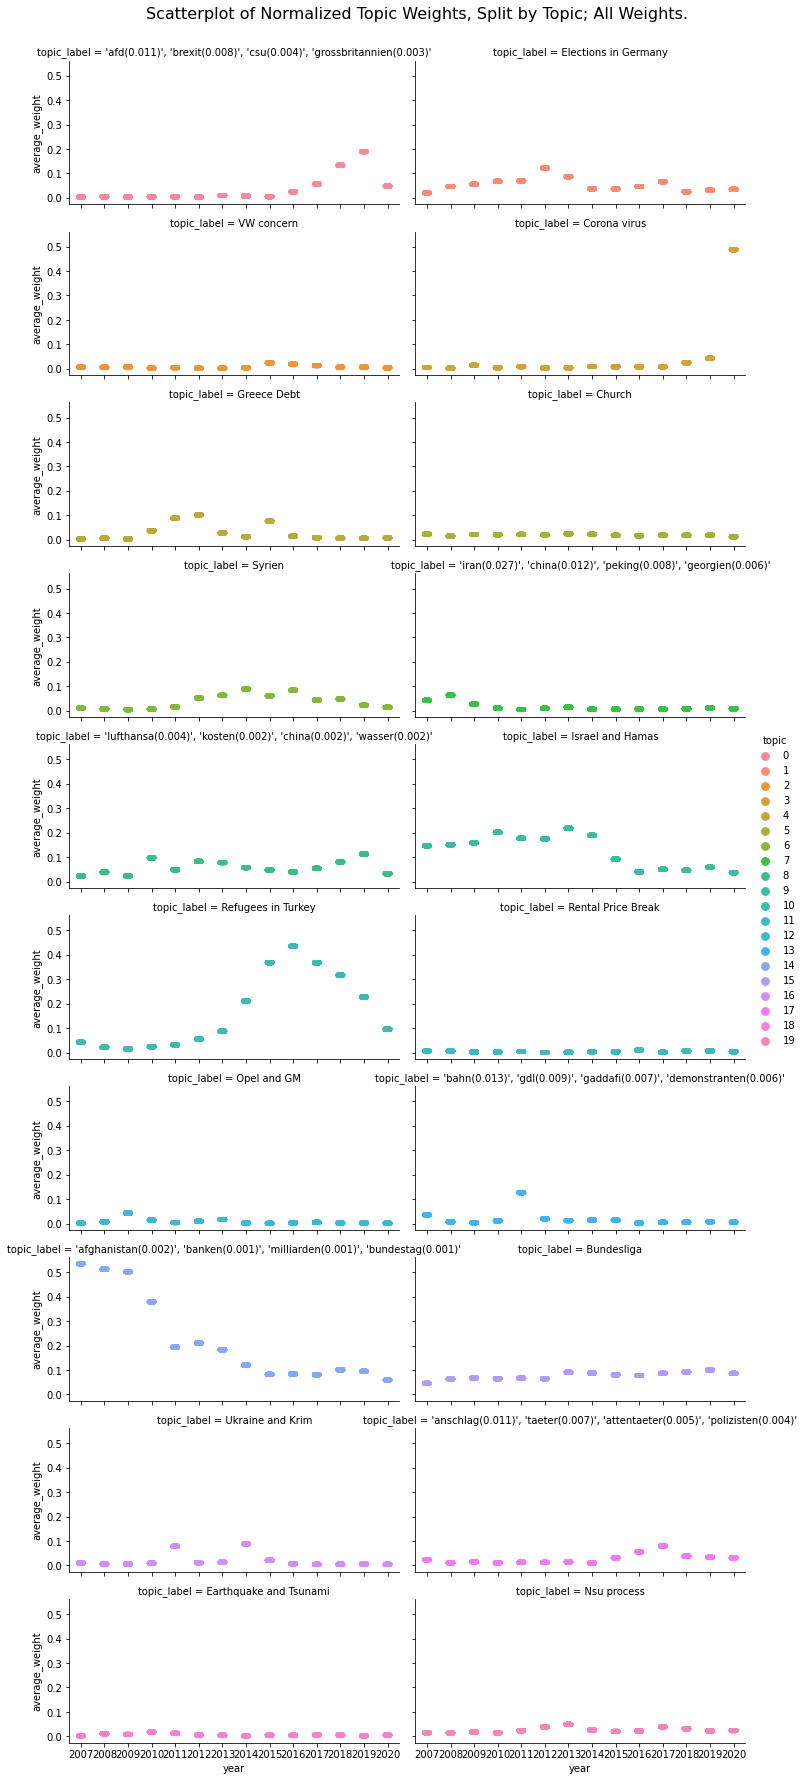

In [101]:
# plot average weights for each year (later normalized)
which_weight = 'average_weight'
#which_weight = 'norm_topic_weight'

df_sum = df12[df12[which_weight] != 0]

print("Max: {}".format(df_sum[which_weight].max()))
print("Min: {}".format(df_sum[which_weight].min()))
print("Average: {}".format(df_sum[which_weight].mean()))
print("Median: {}".format(df_sum[which_weight].median()))
print("Most frequent value: {}".format(df_sum[which_weight].round(5).value_counts().idxmax()))

p = sns.factorplot(x="year", y=which_weight, hue="topic", col='topic_label', col_wrap=2, 
                   kind='strip', height=2.5, aspect=2, jitter=1, data=df_sum)
p.fig.subplots_adjust(top=0.95)
p.fig.suptitle("Scatterplot of Normalized Topic Weights, Split by Topic; All Weights.", fontsize=16)



[(0, "'afd(0.011)', 'brexit(0.008)', 'csu(0.004)', 'grossbritannien(0.003)'"), (1, 'Elections in Germany'), (2, 'VW concern'), (3, 'Corona virus'), (4, 'Greece Debt'), (5, 'Church'), (6, 'Syrien'), (7, "'iran(0.027)', 'china(0.012)', 'peking(0.008)', 'georgien(0.006)'"), (8, "'lufthansa(0.004)', 'kosten(0.002)', 'china(0.002)', 'wasser(0.002)'"), (9, 'Israel and Hamas'), (10, 'Refugees in Turkey'), (11, 'Rental Price Break'), (12, 'Opel and GM'), (13, "'bahn(0.013)', 'gdl(0.009)', 'gaddafi(0.007)', 'demonstranten(0.006)'"), (14, "'afghanistan(0.002)', 'banken(0.001)', 'milliarden(0.001)', 'bundestag(0.001)'"), (15, 'Bundesliga'), (16, 'Ukraine and Krim'), (17, "'anschlag(0.011)', 'taeter(0.007)', 'attentaeter(0.005)', 'polizisten(0.004)'"), (18, 'Earthquake and Tsunami'), (19, 'Nsu process')]
topic_labels
['Corona virus' 'Greece Debt' 'Church' 'Refugees in Turkey' 'Bundesliga']


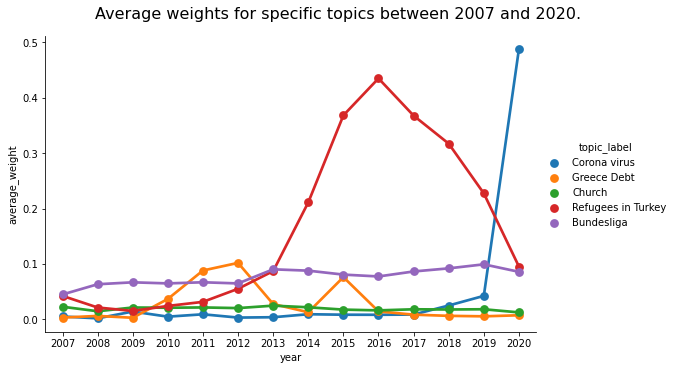

In [104]:

which_weight = 'average_weight'
#which_weight = 'norm_topic_weight'
dfs = df12
#display(df12)
print(data_tuple)
dfs = df12[(df12['topic'] == 3) | (df12['topic'] == 4) | (df12['topic'] == 5) | #todo change
           (df12['topic'] == 10) | (df12['topic'] == 15) | (df12['topic'] == 30)]
nurTopic1 = list(set([i for i in df12['topic_label']]))# if "1" in i]))
#dfs = df12[df12['topic_label'].isin(nurTopic1)]
#display(dfs)
#display(len(dfs),len(df12))
topiic_labels = dfs['topic_label'].unique()
print("topic_labels")
print(topiic_labels)
order = topiic_labels

def create_pointplot(df, y_value, hue=None, order=order, col=None, wrap=None, size=5, aspect=1.5, title=""):
    p = sns.catplot(x="year", y=y_value, kind='point', hue_order=order, hue=hue, 
                       col=col, col_wrap=wrap, col_order=order, height=size, aspect=aspect, data=df)
    p.fig.subplots_adjust(top=0.9)
    p.fig.suptitle(title, fontsize=16)
    return p
def create_bar(df, y_value, hue=None, order=order, col=None, wrap=None, size=5, aspect=1.5, title=""):
    p = sns.catplot(x="year", y=y_value, kind='bar', hue_order=order, hue=hue, 
                       col=col, col_wrap=wrap, col_order=order, height=size, aspect=aspect, data=df)
    p.fig.subplots_adjust(top=0.9)
    p.fig.suptitle(title, fontsize=16)
    return p
create_pointplot(dfs, which_weight, hue='topic_label', order=order, size=5, aspect=1.5,
                 title="Average weights for specific topics between 2007 and 2020.")


In [56]:

############################### From here, just old things/ testing ####################################################################

'''#for lda in lda_models:
#    print(lda)
counter = 0
for lda_model in lda_models:
    if counter<18:
        #print(lda_model)
        #lda_model[1].save("/home/sim/all/Master/Forschungspraktikum/Tagesschau/ldas/ldamodel"+str(lda_model[0])+'topics'+str(0.3)+'filterValue')
    else:
        #print(lda_model)
        #lda_model[1].save("/home/sim/all/Master/Forschungspraktikum/Tagesschau/ldas/ldamodel"+str(lda_model[0])+'topics'+str(0.5)+'filterValue')

    counter+=1
        #lda_model.save("/home/sim/all/Master/Forschungspraktikum/Tagesschau/ldas/ldamodel"+str(lda_model[0]))
#display(pyLDAvis.gensim.prepare(lda_models[0], corpus, id2word))
#id2word = corpora.Dictionary(df['preprocessed'])
#id3word = list(id2word)
#id2word.filter_extremes(no_below = 20, no_above=0.5)
#id2word = list(id2word)
#id4word = [i for i in id3word if str(i) in id3word and str(i) not in id2word]
'''

In [43]:
#tesst = [print(l) for l in open('gensim3.log') if "updating t" in l or "converged" in l or ("pass" in l and "chunk #0" in l)]

display(pd.DataFrame(model_coherences1))
#print((lda1[1]))
#for lda_model in lda1:
    #lda_model.save("ldamodel"+str(counter))
'''lda_model = lda3[0]
print(lda_model)
print("\n------------------------------------------------\n")
for idx,topic in lda_model[1].print_topics(-1):
        probs = ((topic.replace('"','').replace(" ","").split('+')))
        for prob in range(len(probs)):
            probs[prob] = (probs[prob].split("*"))
        probOver001 = [str(x[1])+'('+str(x[0])+')' for x in probs]# if float(x[0])>0.0005]
        print('Topic: {} \nWords: {}'.format(idx+1,probOver001))
        #print('Topic: {} \nWords: {}'.format(idx+1, re.sub('[^A-Za-z ]+', '', topic).replace("  "," ")))
startVis = datetime.datetime.now()
#display(pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary))'''
print()

,Topics,Coherence,filter_value
0,10,0.476181,0.5
1,15,0.539088,0.5
2,20,0.594436,0.5
3,25,0.501541,0.5
4,30,0.459414,0.5
5,35,0.488115,0.5
6,40,0.458521,0.5
...,...,...,...
28,60,0.431860,0.3
29,65,0.433789,0.3


,Topics,Coherence,filter_value
0,10,0.476181,0.5
1,15,0.539088,0.5
2,20,0.594436,0.5
3,25,0.501541,0.5
4,30,0.459414,0.5
5,35,0.488115,0.5
6,40,0.458521,0.5
7,45,0.452575,0.5
8,50,0.453271,0.5
9,55,0.422174,0.5


In [2]:
## train with gensim LDA

df_all_processed = pd.read_csv('~/all/Master/Forschungspraktikum/Tagesschau/ldas/df.csv', sep=',')
df_all_processed.fillna('', inplace=True)
# Visualise the 25 most common words
#plot_25_most_common_words(count_data, count_vectorizer)

#no_above = [0.05,0.1,0.15,0.25,0.35,0.5,0.7,1]
#no_above = [0.25,0.35,0.5]
no_above = [1]
for x in no_above:
    # with gensim lda
    print("Train LDA with no_above:",x,"...")
    startLDA = datetime.datetime.now()
    num_topics = 40
    passes = 2

    lda_model,bow_corpus,dictionary = train_model_gensim(df=df_all_processed,num_topics=num_topics,passes=passes,workers=7,no_above=x)
    
    # Save model to disk.
    lda_model.save("lda_"+str(num_topics)+"topics_"+str(passes)+"passes_"+str(x)+"no_above")
    
    #lda_model1,bow_corpus1,dictionary1 = train_model_gensim_seq_lda(df=df_all_processed,num_topics=20,passes=10,workers=7,yearsLen=yearsLen)
    endLDA = datetime.datetime.now()
    print("lda training needs:",(endLDA-startLDA).total_seconds(),"seconds")
    for idx,topic in lda_model.print_topics(-1):
        probs = ((topic.replace('"','').replace(" ","").split('+')))
        for prob in range(len(probs)):
            probs[prob] = (probs[prob].split("*"))
        probOver001 = [str(x[1])+'('+str(x[0])+')' for x in probs]# if float(x[0])>0.0005]
        print('Topic: {} \nWords: {}'.format(idx+1,probOver001))
        #print('Topic: {} \nWords: {}'.format(idx+1, re.sub('[^A-Za-z ]+', '', topic).replace("  "," ")))
    #"""
    """
    # with sklearn lda
    lda_model = train_lda_sklearn(df_processed,count_vectorizer,count_data,number_topics=n_topics,number_words=n_words,ngram_tuple=(2,3),stop_words=None)
    print_topics(lda_model, count_vectorizer, n_words)
    del df_processed
    del count_data
    del lda_model
    #print("loop needed:",(end-start).total_seconds(),"seconds")
    #"""
    #"""
    startVis = datetime.datetime.now()
    display(pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary))
    endVis = datetime.datetime.now()
    print((endVis-startVis).total_seconds(),"seconds")
print(dictionary)
print("\ndone")

Train LDA with no_above: 1 ...


2020-12-21 18:13:17,847:INFO:adding document #0 to Dictionary(0 unique tokens: [])
2020-12-21 18:13:22,428:INFO:built Dictionary(162950 unique tokens: ['abbas', 'abend', 'abend_damen_herren', 'abstiegsplaetzen', 'abstiegsraenge']...) from 4932 documents (total 4110057 corpus positions)
2020-12-21 18:13:22,669:INFO:discarding 141909 tokens: [('anspringen', 6), ('anzurichten', 8), ('arroganz', 14), ('aufbauprogramm', 2), ('belehren', 8), ('beschauer', 2), ('boxweltmeister', 16), ('brauchste', 2), ('buergertelefon', 2), ('christiansen', 12)]...
2020-12-21 18:13:22,669:INFO:keeping 21041 tokens which were in no less than 20 and no more than 4932 (=100.0%) documents


The word "corona" appears in 281 documents
The word "betreuung" appears in 153 documents
number words in dictionary before: 162950


2020-12-21 18:13:22,742:INFO:resulting dictionary: Dictionary(21041 unique tokens: ['abbas', 'abend', 'abend_damen_herren', 'abstiegsplaetzen', 'abstiegsraenge']...)


The word "spd" appears in 2598 documents
number words in dictionary after noAbove: 21041


2020-12-21 18:13:24,583:INFO:using symmetric alpha at 0.025
2020-12-21 18:13:24,584:INFO:using symmetric eta at 0.025
2020-12-21 18:13:24,586:INFO:using serial LDA version on this node
2020-12-21 18:13:24,646:INFO:running online LDA training, 40 topics, 2 passes over the supplied corpus of 4932 documents, updating every 4928 documents, evaluating every ~4928 documents, iterating 50x with a convergence threshold of 0.001000
2020-12-21 18:13:24,646:WARNING:too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-12-21 18:13:24,648:INFO:training LDA model using 7 processes


workers 7


2020-12-21 18:13:24,815:INFO:PROGRESS: pass 0, dispatched chunk #0 = documents up to #704/4932, outstanding queue size 1
2020-12-21 18:13:24,931:INFO:PROGRESS: pass 0, dispatched chunk #1 = documents up to #1408/4932, outstanding queue size 2
2020-12-21 18:13:24,965:INFO:PROGRESS: pass 0, dispatched chunk #2 = documents up to #2112/4932, outstanding queue size 3
2020-12-21 18:13:24,969:INFO:PROGRESS: pass 0, dispatched chunk #3 = documents up to #2816/4932, outstanding queue size 4
2020-12-21 18:13:24,973:INFO:PROGRESS: pass 0, dispatched chunk #4 = documents up to #3520/4932, outstanding queue size 5
2020-12-21 18:13:24,977:INFO:PROGRESS: pass 0, dispatched chunk #5 = documents up to #4224/4932, outstanding queue size 6
2020-12-21 18:13:25,125:INFO:PROGRESS: pass 0, dispatched chunk #6 = documents up to #4928/4932, outstanding queue size 7
2020-12-21 18:13:25,127:INFO:PROGRESS: pass 0, dispatched chunk #7 = documents up to #4932/4932, outstanding queue size 8
2020-12-21 18:13:42,740:I

2020-12-21 18:13:56,674:INFO:topic #14 (0.025): 0.006*"menschen" + 0.004*"deutschland" + 0.003*"nacht" + 0.003*"eu" + 0.003*"deutsche" + 0.003*"deutschen" + 0.003*"mal" + 0.002*"regierung" + 0.002*"land" + 0.002*"berlin"
2020-12-21 18:13:56,676:INFO:topic #15 (0.025): 0.005*"menschen" + 0.004*"deutschland" + 0.003*"nacht" + 0.003*"eu" + 0.003*"regierung" + 0.002*"deutschen" + 0.002*"usa" + 0.002*"spd" + 0.002*"land" + 0.002*"sueden"
2020-12-21 18:13:56,677:INFO:topic #16 (0.025): 0.004*"deutschland" + 0.004*"menschen" + 0.003*"regierung" + 0.003*"berlin" + 0.002*"mal" + 0.002*"deutschen" + 0.002*"spd" + 0.002*"nacht" + 0.002*"deutsche" + 0.002*"eu"
2020-12-21 18:13:56,678:INFO:topic #17 (0.025): 0.005*"deutschland" + 0.004*"menschen" + 0.003*"eu" + 0.003*"nacht" + 0.003*"deutsche" + 0.003*"berlin" + 0.003*"deutschen" + 0.003*"regierung" + 0.003*"mal" + 0.002*"land"
2020-12-21 18:13:56,680:INFO:topic #18 (0.025): 0.004*"eu" + 0.003*"regierung" + 0.003*"menschen" + 0.003*"nacht" + 0.003*

lda training needs: 39.092713 seconds
Topic: 1 
Words: ['deutschland(0.005)', 'spd(0.004)', 'menschen(0.004)', 'nacht(0.003)', 'regierung(0.003)', 'land(0.003)', 'cdu(0.002)', 'sueden(0.002)', 'deutschen(0.002)', 'regen(0.002)']
Topic: 2 
Words: ['deutschland(0.005)', 'menschen(0.003)', 'eu(0.003)', 'nacht(0.003)', 'mal(0.002)', 'land(0.002)', 'deutschen(0.002)', 'steht(0.002)', 'spd(0.002)', 'regierung(0.002)']
Topic: 3 
Words: ['menschen(0.005)', 'deutschland(0.004)', 'regierung(0.003)', 'nacht(0.002)', 'corona(0.002)', 'land(0.002)', 'deutsche(0.002)', 'mal(0.002)', 'klar(0.002)', 'russland(0.002)']
Topic: 4 
Words: ['deutschland(0.004)', 'spd(0.004)', 'menschen(0.004)', 'regierung(0.003)', 'nacht(0.003)', 'eu(0.003)', 'deutschen(0.003)', 'mal(0.003)', 'land(0.003)', 'grad(0.002)']
Topic: 5 
Words: ['menschen(0.004)', 'regierung(0.003)', 'berlin(0.003)', 'nacht(0.003)', 'deutschland(0.003)', 'mal(0.003)', 'eu(0.002)', 'spd(0.002)', 'deutsche(0.002)', 'deutschen(0.002)']
Topic: 6 
Wo

2020-12-21 18:14:07,098:INFO:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2020-12-21 18:14:07,099:INFO:NumExpr defaulting to 8 threads.


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13    -0.003752 -0.000259       1        1  17.660555
37     0.003122  0.002665       2        1  16.487654
35    -0.001956  0.004507       3        1  16.014477
15    -0.001567  0.001158       4        1  13.846263
3      0.005847  0.000896       5        1  10.668972
...         ...       ...     ...      ...        ...
27     0.001712  0.001923      36        1   0.006842
21    -0.001983  0.000667      37        1   0.003868
31    -0.000532  0.000775      38        1   0.003462
32     0.002559  0.001107      39        1   0.003427
11    -0.000240 -0.002136      40        1   0.003427

[40 rows x 5 columns], topic_info=             Term          Freq         Total Category  logprob  loglift
279      menschen  15494.000000  15494.000000  Default  30.0000  30.0000
92    deutschland  16173.000000  16173.000000  Default  29.0000  29.0000
344     regierung  12116.000000  12116.000000  Default  28.0000  28.0000
297         nacht  10493.000000  10493.000000  Default  27.0000  27.0000
131            eu   9048.000000   9048.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
342         regen      0.184186   5452.667480  Topic40  -6.5069  -0.0143
1297        sagen      0.158108   4192.895020  Topic40  -6.6596   0.0957
271           mal      0.196832   8657.869141  Topic40  -6.4405  -0.4103
731          klar      0.161454   4989.012695  Topic40  -6.6387  -0.0572
398        sueden      0.166201   7033.435059  Topic40  -6.6097  -0.3716

[3308 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
1          1  0.177272    abend
1          2  0.154818    abend
1          3  0.181605    abend
1          4  0.126060    abend
1          5  0.137484    abend
...      ...       ...      ...
17594      8  0.063403  zyperns
17594      9  0.021134  zyperns
17594     10  0.021134  zyperns
17594     12  0.021134  zyperns
17594     13  0.021134  zyperns

[24785 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 38, 36, 16, 4, 13, 34, 23, 1, 18, 2, 3, 39, 6, 30, 11, 7, 40, 29, 25, 31, 19, 27, 17, 8, 37, 24, 26, 35, 5, 15, 21, 20, 9, 10, 28, 22, 32, 33, 12])

21.669468 seconds
Dictionary(21041 unique tokens: ['abbas', 'abend', 'abend_damen_herren', 'abstiegsplaetzen', 'abstiegsraenge']...)

done


In [110]:
# Compute Coherence Score
df_all_processed = pd.read_csv('~/all/Master/Forschungspraktikum/Tagesschau/ldas/df.csv', sep=',')
df_all_processed.fillna('', inplace=True)
df = df_all_processed.copy()
for i in range(len(df['preprocessed'])):
        df.at[i,'preprocessed'] = df.loc[i,'preprocessed'].split(" ")
dictionary = corpora.Dictionary(df['preprocessed'])
bow_corpus = [dictionary.doc2bow(doc) for doc in df['preprocessed']]

print("coherence training:")
coherence_model_lda = CoherenceModel(model=lda_model, texts=df['preprocessed'].tolist(), dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

coherence training:

Coherence Score:  0.48511085308032403


In [26]:
  data_tuple 

[(0, 'UkraineRussland1'),
 (1, 'TürkeiAnschlag1'),
 (2, 'Coronavirus'),
 (3, 'Syrien1'),
 (4, 'Flüchtlinge1'),
 (5, 'Wahlen in Deutschland'),
 (6, 'Bankenkrise'),
 (7, 'Katholische Kirche1'),
 (8, 'Doping Tour de France1'),
 (9, 'Griechenland(Euro)1'),
 (10, 'Loveparade Duisburg'),
 (11, 'Sturmschäden1'),
 (12, 'Bundesliga1'),
 (13, 'Afhanistan1'),
 (14, 'Agypten1'),
 (15, 'Nordkorea-Südkorea1'),
 (16, 'urteilBahn3'),
 (17, 'WasserDemo-LibyenGaddafi2'),
 (18, 'HamasIsraelGazastreifen1'),
 (19, 'afd Trump Turkei3')]

In [ ]:
### tot test; laufzeit steigt mehr als linear, noch nicht auf datensatz testen können.
#,'france','','','','','','','',''
'''
from gensim.models.wrappers.dtmmodel import DtmModel

doc_topic, topic_term, doc_lengths, term_frequency, vocab = lda_model1.dtm_vis(time=0, corpus=bow_corpus1)
vis_dtm = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_dtm)
lda_model1.print_topics(time=0)'''
doc = nlp("Hamburg ist eine schöne Stadt, Dresden auch. Die Hamas in France ist stark.")

for token in doc:
    1==1
    #print(token.text, token.pos_, token.tag_, token.dep_,
             token.is_stop)

In [ ]:
#%%time
############################### preprocess and train for each year separately for a given daterange ####################################

'''
path = "/home/sim/all/Master/Forschungspraktikum/Tagesschau/transcripts/"
n_cpu_cores = 13 #int(os.cpu_count()-1)
print("number cpu_cores to use:",n_cpu_cores)

#load s2t transcriptions
path = "/home/sim/all/Master/Forschungspraktikum/Tagesschau/transcripts/"
transcriptions = load_transcriptions(path)
keys = ['2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020']
years_dict = {}
for year in keys: 
    years_dict[year] = []

# lda for certain dates
daterange = pd.date_range(datetime.datetime(2007, 1, 1), datetime.datetime(2020, 7, 31))
dates_of_interest = []
for date in daterange:
    for i in transcriptions:
        if 'tagesschau' in i and 'vor' not in i:
            year = int((i.split('_')[1][4:8]))
            if year==date.year:
                month = int((i.split('_')[1][2:4]))
                if month == date.month:
                    day = int((i.split('_')[1][0:2]))
                    if day == date.day:
                        years_dict[str(year)].append(i)
                        dates_of_interest.append(i)
print("There are ",len(dates_of_interest),"transcriptions in given daterange")

#"""
for year in years_dict.keys():
    print("\npreprocess transcriptions of year:",year,"quantity:",len(years_dict[str(year)]))
    if len(years_dict[str(year)]) == 0:
        print("no transcription for year:",year)
        continue
    start = datetime.datetime.now()
    #transcriptions = transcriptions[i*50:(i+1)*50]
    transcriptions = years_dict[str(year)]
    # maybe: more threads -> more RAM so in case of low ram use less cores


    df_processed,df1 = preprocess_transcriptions(transcriptions,number_cpu_cores=n_cpu_cores)
    #print_workcloud(df_processed['preprocessed'])

    # Initialise count vectorizer
    count_vectorizer = CountVectorizer(ngram_range=(1,1))
    # Fit and transform the processed titlest
    count_data = count_vectorizer.fit_transform(df_processed['preprocessed'])
    #params for LDA
    n_topics = 10 #alpha
    n_words = 5 #beta

    # Visualise the 10 most common words
    #plot_25_most_common_words(count_data, count_vectorizer)
    
    #"""
    # with gensim lda
    startLDA = datetime.datetime.now()
    lda_model,bow_corpus,dictionary = train_model_gensim(df=df_processed,num_topics=20,passes=10,workers=7)
    endLDA = datetime.datetime.now()
    print("lda training needs:",(endLDA-startLDA).total_seconds(),"seconds")
    for idx, topic in lda_model.print_topics(-1):
        print('Topic: {} \nWords: {}'.format(idx+1, re.sub('[^A-Za-z ]+', '', topic).replace("  "," ")))
    
    #"""
    """
    # with sklearn lda
    lda_model = train_lda_sklearn(df_processed,count_vectorizer,count_data,number_topics=n_topics,number_words=n_words,ngram_tuple=(2,3),stop_words=None)
    print_topics(lda_model, count_vectorizer, n_words)
    del df_processed
    del count_data
    del lda_model
    #print("loop needed:",(end-start).total_seconds(),"seconds")
    #"""
    startVis = datetime.datetime.now()
    display(pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary))
    endVis = datetime.datetime.now()
    print((endVis-startVis).total_seconds(),"seconds")
'''
#"""

In [40]:
testDF = pd.DataFrame(columns=['eins','zwei','drei'])
testDF.at[0,'eins'] = 1
testDF.at[0,'zwei'] = 2
testDF.at[0,'drei'] = 3
testDF.at[1,'eins'] = 11
testDF.at[1,'zwei'] = 13
testDF.at[1,'drei'] = 15
testDF.at[2,'eins'] = 20
testDF.at[2,'zwei'] = 21
testDF.at[2,'drei'] = 22
testDF.at[3,'eins'] = 11
testDF.at[3,'zwei'] = 13
testDF.at[3,'drei'] = 32
testDF.at[4,'eins'] = 11
testDF.at[4,'zwei'] = 13
testDF.at[4,'drei'] = 22
display(testDF)

(testDF.groupby(['eins','zwei']).agg({'drei':'sum'}))

,eins,zwei,drei
0,1,2,3
1,11,13,15
2,20,21,22
3,11,13,32
4,11,13,22


,,drei
eins,zwei,
1,2,3
11,13,69
20,21,22
